In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster(memory_limit='16GB')
# client = Client(cluster)
# client

In [3]:
import sys
from pathlib import Path
import pandas as pd
import tarfile
import urllib

def load_metadata():
  file_path = Path("data/train.csv")
  return pd.read_csv(file_path)
  
metadata = load_metadata()

def extract_eeg():
  eeg_dir = Path("../data/eeg")
  tarball_path = Path("data/eeg.tar.gz")
  if not tarball_path.is_file():
    url = 'https://dl.dropboxusercontent.com/scl/fi/5sina48c4naaxv6uze0fv/eeg.tar.gz?rlkey=r7ec191extynfcm8fy0tsiws5&dl=0'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as eeg_tarball:
      eeg_tarball.extractall()
    
extract_eeg()

metadata

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [4]:
# Add a unique id to each sample
from src.utils.utils import compute_signal_hash

def compute_unique_id(row):
  return str(compute_signal_hash(row))

metadata['unique_id'] = metadata.apply(compute_unique_id, axis=1)

cols = metadata.columns.tolist()
cols = [cols[-1]] + cols[:-1]
metadata = metadata[cols]
metadata


,unique_id,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,db76e9927,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,0e1116d9d,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,8ec6d3c8c,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,662b0bd39,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,ca946aadb,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,368247dd8,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,a7a60ad75,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,97f63909c,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,a5399830b,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [5]:
import dask.dataframe as dd
from src.utils import compute_signal_hash

channel_order = ['Fp1', 'Fp2',
            'F7', 'F3', 'Fz', 'F4', 'F8', 
            'T3', 'C3', 'Cz', 'C4', 'T4', 
            'T5', 'P3', 'Pz', 'P4', 'T6', 
            'O1', 'O2',
          ]

def load_signals(metadata):
  rows = len(metadata)
  eeg_list = []

  for row in range(0,rows):
    sample = metadata.iloc[row]
    f_name = f'data/eeg/{sample.eeg_id}.parquet'
    eeg = pd.read_parquet(f_name)[channel_order]
    eeg_offset = int(sample.eeg_label_offset_seconds)

    eeg['unique_id'] = sample['unique_id']
    eeg = eeg.set_index('unique_id')

    eeg = eeg.iloc[eeg_offset*200:(eeg_offset+50)*200]
    eeg_list.append(eeg)

  return dd.concat(eeg_list)

ddf = load_signals(metadata)


In [6]:
# Compute 150 signals to start
df = ddf.compute()
eeg_ids = list(set(df.index))
df

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
unique_id,,,,,,,,,,,,,,,,,,,
db76e9927,-14.780000,-33.049999,-8.910000,-5.600000,-21.650000,1.780000,-26.129999,9.850000,-16.209999,-33.310001,-17.459999,3.22,-5.170000,-14.370000,-13.94,-24.629999,-4.620000,-27.780001,-17.980000
db76e9927,-8.100000,-34.610001,-26.570000,-2.770000,-20.350000,0.660000,-35.130001,13.400000,-16.600000,-36.060001,-17.309999,15.12,-3.140000,-15.580000,-15.91,-25.969999,-1.740000,-28.480000,-20.629999
db76e9927,-3.530000,-34.709999,17.120001,15.570000,-19.110001,-0.770000,-24.709999,30.219999,-8.930000,-32.369999,-23.840000,-2.82,14.670000,-6.310000,-8.61,-20.760000,4.840000,-18.500000,-10.460000
db76e9927,-3.370000,-29.330000,13.520000,11.710000,-20.629999,-4.140000,10.330000,24.660000,-10.640000,-33.750000,-32.400002,-4.81,14.880000,-5.840000,-11.61,-24.910000,-2.940000,-18.680000,-13.950000
db76e9927,-3.830000,-27.459999,14.320000,-2.420000,-20.000000,-3.300000,-9.990000,19.590000,-12.090000,-35.860001,-27.650000,7.83,4.900000,-11.270000,-16.00,-27.860001,-4.780000,-25.540001,-20.190001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bbdf2f28e,-39.990002,-11.380000,14.590000,-20.500000,-15.240000,-23.340000,-57.529999,-12.530000,7.420000,-20.930000,-16.010000,1.68,-3.070000,-1.150000,2.43,-0.170000,-23.500000,-6.850000,3.350000
bbdf2f28e,-74.470001,-50.410000,-10.230000,-46.110001,-35.630001,-53.380001,-85.099998,-32.070000,-14.630000,-38.250000,-40.669998,-25.49,-22.780001,-22.990000,-15.43,-26.559999,-49.869999,-26.160000,-22.389999
bbdf2f28e,-66.209999,-31.180000,-4.690000,-39.560001,-26.389999,-49.680000,-75.089996,-27.030001,-7.510000,-28.959999,-32.930000,-10.00,-10.790000,-11.880000,-5.56,-20.100000,-42.110001,-11.150000,-14.310000


In [7]:
# Apply filtering
from src.preprocessing.preprocessing import bp_filter, notch_filter

# Apply notch filter to remove powerline frequency
notch_filtered = notch_filter(df, 60)
bp_filtered = bp_filter(notch_filtered, 0.5, 50)

Creating RawArray with float64 data, n_channels=19, n_times=10000000
    Range : 0 ... 9999999 =      0.000 ... 49999.995 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Creating RawArray with float64 data, n_channels=19, n_times=10000000
    Range : 0 ... 9999999 =      0.000 ... 49999.995 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s


In [8]:
# from src.preprocessing.preprocessing import wavelet_transform
# from src.visualize import plot_signal
# import numpy as np

# sig = df.loc['db76e9927']

# plot_signal(sig, 5, ['F3',	'Fz',	'F4',	'F8',	'T3'])


In [9]:
from src.preprocessing.preprocessing import wavelet_transform

sig_denoised = wavelet_transform(bp_filtered, 2, basis='bior3.3')

Extracting top 3 channels based on max variance for all samples
- 1000 samples computation duration = approx. 15 minutes

In [10]:
from src.feature_extraction import calculate_all_samples

top_channels_df = calculate_all_samples(df, eeg_ids, len(eeg_ids))
top_channels_df

,0,1,2
edf588e87,T6,O2,T4
0597991df,Fp1,Fz,P3
58433b98c,Cz,O1,P3
213e6cec7,Fp1,Fp2,F8
49124f0d2,F7,Fp1,P3
...,...,...,...
d3a800a2e,O2,T5,Fp2
c9946ef2d,P3,F3,Fp1
324961cd9,C3,P3,Fp2
702cd05a8,Fz,F4,Cz


Extracting Statistical Features from every sample with extraction function
- 1000 samples computation duration = approx. 20 minutes

In [11]:
from src.feature_extraction import extract_features_all_samples

features_df = extract_features_all_samples(df, top_channels_df)
features_df

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow
edf588e87,112.543826,-21.001388,292.680003,-761.050028,14314.831055,-8.163333,-2.776157,16.665283,5.261551,8386661450.666667,1501740141942.962158
0597991df,3856.477743,744.094017,20949.180176,-11791.030355,29315600.239583,-38.506668,2.041563,15.582863,5.460681,25695307216060416.0,3058166780195150.5
58433b98c,109.163197,-20.572291,272.04334,-451.773326,23932.096395,-18.628333,-0.686824,5.348869,4.76578,2577570971.166667,2482795691462.661621
213e6cec7,88.448036,1.914313,454.24,-509.636668,8024.95931,9.375,-1.266241,7.255427,5.379963,507509482.666667,803231993427.428101
49124f0d2,5147.964274,376.090216,42078.802083,-16072.089844,29203002.0,-109.651667,5.046888,41.65616,5.414965,26752821932064768.0,2943717220776361.5
...,...,...,...,...,...,...,...,...,...,...,...
d3a800a2e,109.508223,-12.846511,272.856664,-709.400014,18702.881999,-3.185,-2.18508,13.459215,5.372697,18080359760.0,1908253226436.50293
c9946ef2d,554.930272,18.172928,2612.830037,-3282.976603,584206.925781,-0.115,-0.619358,8.28131,5.574496,10644380907861.333984,58470676970561.09375
324961cd9,41.524794,-9.692143,188.21667,-144.909999,1860.023783,-17.116667,0.803181,5.22177,5.244672,21268364.0,200257315612.974884
702cd05a8,26.392301,-7.461284,82.586665,-108.103335,696.633362,-5.67,-0.286147,3.075018,5.076384,1492535.5,77834876497.104477


Setting up Feature Data and Target Data for correct format to split data and Input to Microsoft's Light Gradient Boosting Machine (LGBM)

In [12]:
# Setup feature table
# input_df = pd.merge(features_df, metadata[['unique_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']], left_index=True, right_on='unique_id')
input_df = pd.merge(features_df, metadata[['unique_id', 'expert_consensus']], left_index=True, right_on='unique_id')
input_df = input_df.set_index('unique_id')
input_df

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow,expert_consensus
unique_id,,,,,,,,,,,,
edf588e87,112.543826,-21.001388,292.680003,-761.050028,14314.831055,-8.163333,-2.776157,16.665283,5.261551,8386661450.666667,1501740141942.962158,LPD
0597991df,3856.477743,744.094017,20949.180176,-11791.030355,29315600.239583,-38.506668,2.041563,15.582863,5.460681,25695307216060416.0,3058166780195150.5,Seizure
58433b98c,109.163197,-20.572291,272.04334,-451.773326,23932.096395,-18.628333,-0.686824,5.348869,4.76578,2577570971.166667,2482795691462.661621,Seizure
213e6cec7,88.448036,1.914313,454.24,-509.636668,8024.95931,9.375,-1.266241,7.255427,5.379963,507509482.666667,803231993427.428101,LPD
49124f0d2,5147.964274,376.090216,42078.802083,-16072.089844,29203002.0,-109.651667,5.046888,41.65616,5.414965,26752821932064768.0,2943717220776361.5,Other
...,...,...,...,...,...,...,...,...,...,...,...,...
d3a800a2e,109.508223,-12.846511,272.856664,-709.400014,18702.881999,-3.185,-2.18508,13.459215,5.372697,18080359760.0,1908253226436.50293,GPD
c9946ef2d,554.930272,18.172928,2612.830037,-3282.976603,584206.925781,-0.115,-0.619358,8.28131,5.574496,10644380907861.333984,58470676970561.09375,Other
324961cd9,41.524794,-9.692143,188.21667,-144.909999,1860.023783,-17.116667,0.803181,5.22177,5.244672,21268364.0,200257315612.974884,LPD


In [180]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


x = input_df.iloc[:, :11].astype(float)
y = input_df[['expert_consensus']].to_numpy().flatten()

categories = ['Seizure', 'LPD', 'GPD', 'LRDA', 'GRDA', 'Other']

le = LabelEncoder()
le.fit(categories)
y = le.transform(y)

# 11 is 42%
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

Inputting Parameters for LGBM Model
- parameters were obtained by observing similiar implementation in same competition project using LGBM library. (see report doc --> citations/acknowledgements for more details) 
- Slight adjustments to parameters applied to fit our implementation

In [181]:
import lightgbm as lgb

params = {
    'objective': 'multiclass',
    'num_class': 6,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'num_leaves': 121,
    'learning_rate': 0.018623105710769177,
    'feature_fraction': 1.0,
    'bagging_fraction': 0.756777580360579,
    'max_depth': 8,
    'verbose': 0
}

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 11
[LightGBM] [Info] Start training from score -1.779337
[LightGBM] [Info] Start training from score -1.779337
[LightGBM] [Info] Start training from score -2.002481
[LightGBM] [Info] Start training from score -1.872427
[LightGBM] [Info] Start training from score -1.801810
[LightGBM] [Info] Start training from score -1.566618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

LGBMClassifier()

In [182]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = lgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.44

Splitting Data 80/20 and adjusting params to obtain training and testing sets

Training our LGBM model on the training data and evaluating it on the test data - Probabilities for each target label are obtained and Displayed

Generating Confusion Matrix with predicted labels and true labels

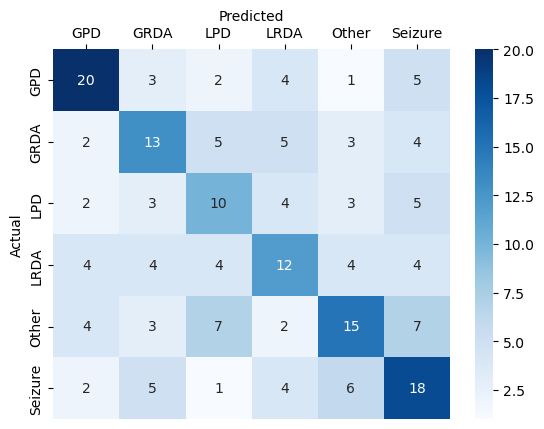

In [183]:
# Generate confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = lgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm)

cm_df.columns = le.inverse_transform([0,1,2,3,4,5]).tolist()
cm_df.index = le.inverse_transform([0,1,2,3,4,5]).tolist()

hm = sns.heatmap(cm_df, annot=True, cmap='Blues')
hm.set_xlabel('Predicted')
hm.set_ylabel('Actual')

hm.xaxis.set_label_position('top')
hm.xaxis.tick_top()

Generating result metrics to evaluate our multiclassification model

In [184]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.44
Precision: 0.4429364958823377
Recall: 0.44
F1 Score: 0.4401015759449992


Preprocessing Data: Applying Wavelet Transform, Notch filter, Standardization to our data
- Model was trained without preprocessing due to higher scores without

In [168]:
# File created to test the correctness of extracted values using MATLAB
# Save Fp1 channel data into a MATLAB file
# import scipy.io
# scipy.io.savemat('Fp1_data.mat', {'Fp1_data': sig1['Fp1']})